In [1]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [2]:
# Avoid OOM error by setting GPU Memory Consumption to Growth
gpus = tf.config.list_physical_devices('GPU')
if (len(gpus) > 0) :
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print('You do not have a GPU available')

You do not have a GPU available


(194, 259, 3)


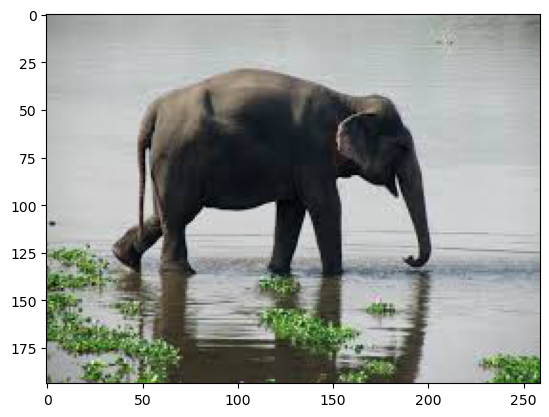

In [3]:
# Viewing an Image
img = cv2.imread(os.path.join("data", "train", "Asian", 'as_tr1.jpg'))
print(img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
train_dir="./data/train/"
test_dir = "./data/test"

In [5]:
# Define image size
IMG_SIZE = (224, 224)

# Create a training dataset
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    label_mode="binary",
    batch_size=32  # This is generally a good batch size
)

# Create a test dataset
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    image_size=IMG_SIZE,
    label_mode="binary",
)

Found 840 files belonging to 2 classes.
Found 188 files belonging to 2 classes.


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
normalization_layer = layers.Rescaling(1./255)

In [8]:
# Data augmentation
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(IMG_SIZE[0],IMG_SIZE[0],3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

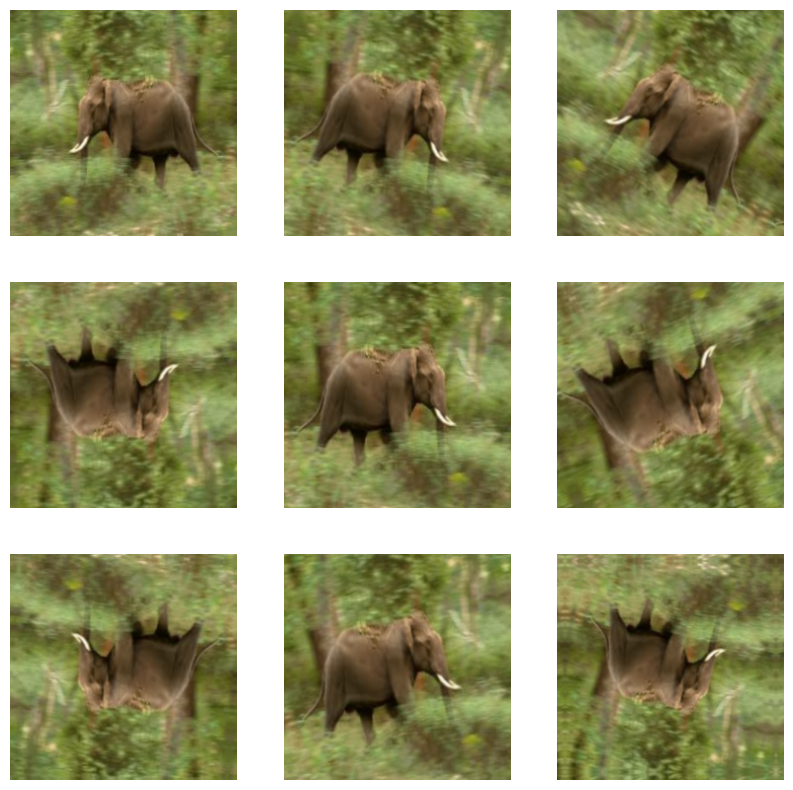

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [10]:
checkpoint_path = "model_checkpoint"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=1) # don't print out whether or not model is being saved

In [11]:
model_one = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
  tf.keras.layers.Conv2D(filters=10,
                         kernel_size=3, # can also be (3, 3)
                         activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

In [12]:
model_one.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [13]:
history_one = model_one.fit(train_data,
                        epochs=20,
                        steps_per_epoch=len(train_data),
                        validation_data=train_data,
                        validation_steps=len(train_data))

Epoch 1/20
27/27 [==============================] - 24s 836ms/step - loss: 0.6984 - accuracy: 0.5202 - val_loss: 0.6876 - val_accuracy: 0.5095
Epoch 2/20
27/27 [==============================] - 23s 841ms/step - loss: 0.6845 - accuracy: 0.5679 - val_loss: 0.6688 - val_accuracy: 0.6107
Epoch 3/20
27/27 [==============================] - 22s 812ms/step - loss: 0.6600 - accuracy: 0.6107 - val_loss: 0.6310 - val_accuracy: 0.6417
Epoch 4/20
27/27 [==============================] - 22s 805ms/step - loss: 0.6211 - accuracy: 0.6464 - val_loss: 0.5901 - val_accuracy: 0.7202
Epoch 5/20
27/27 [==============================] - 22s 832ms/step - loss: 0.5626 - accuracy: 0.7369 - val_loss: 0.5323 - val_accuracy: 0.7190
Epoch 6/20
27/27 [==============================] - 23s 854ms/step - loss: 0.5024 - accuracy: 0.7429 - val_loss: 0.4291 - val_accuracy: 0.8310
Epoch 7/20
27/27 [==============================] - 24s 899ms/step - loss: 0.4225 - accuracy: 0.8131 - val_loss: 0.3588 - val_accuracy: 0.8595

In [14]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

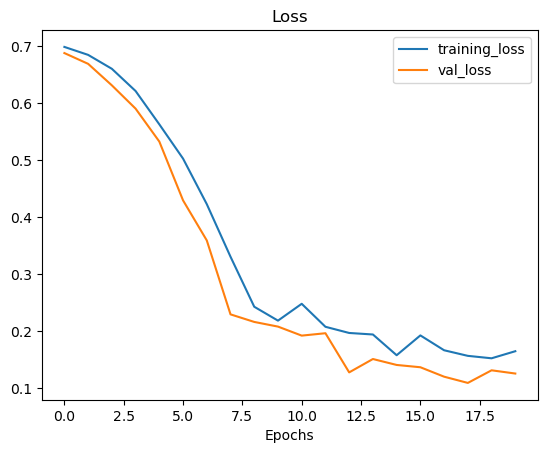

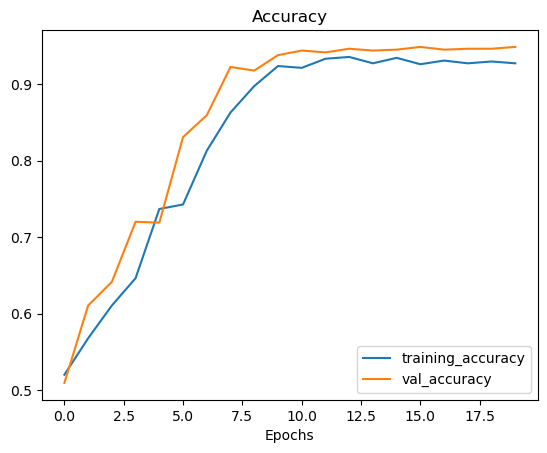

In [15]:
plot_loss_curves(history_one)

In [16]:
model_one_ev = model_one.evaluate(test_data)
model_one_ev

6/6 [==============================] - 4s 309ms/step - loss: 0.6575 - accuracy: 0.7394


[0.6574941873550415, 0.7393617033958435]

In [17]:
model_two = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(filters=10,
                         kernel_size=3, # can also be (3, 3)
                         activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
], name="model_two")

In [18]:
model_two.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [19]:
checkpoint_path = "model_checkpoint_conv4" # saving weights requires ".ckpt" extension
mc = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
#                                                       save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=1) # don't print out whether or not model is being saved

In [20]:
history_two = model_two.fit(train_data,
                        epochs=20,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[mc])

Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 1.4189 - accuracy: 0.5560
Epoch 1: val_accuracy improved from -inf to 0.51064, saving model to model_checkpoint_conv4
INFO:tensorflow:Assets written to: model_checkpoint_conv4\assets


INFO:tensorflow:Assets written to: model_checkpoint_conv4\assets


27/27 [==============================] - 85s 3s/step - loss: 1.4189 - accuracy: 0.5560 - val_loss: 0.7020 - val_accuracy: 0.5106
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 1.7129 - accuracy: 0.5310
Epoch 2: val_accuracy did not improve from 0.51064
27/27 [==============================] - 66s 2s/step - loss: 1.7129 - accuracy: 0.5310 - val_loss: 0.6948 - val_accuracy: 0.5106
Epoch 3/20
27/27 [==============================] - ETA: 0s - loss: 1.4732 - accuracy: 0.5500
Epoch 3: val_accuracy did not improve from 0.51064
27/27 [==============================] - 64s 2s/step - loss: 1.4732 - accuracy: 0.5500 - val_loss: 0.9824 - val_accuracy: 0.4840
Epoch 4/20
27/27 [==============================] - ETA: 0s - loss: 1.6666 - accuracy: 0.5500
Epoch 4: val_accuracy did not improve from 0.51064
27/27 [==============================] - 63s 2s/step - loss: 1.6666 - accuracy: 0.5500 - val_loss: 0.8315 - val_accuracy: 0.4521
Epoch 5/20
27/27 [==============================]

INFO:tensorflow:Assets written to: model_checkpoint_conv4\assets


27/27 [==============================] - 76s 3s/step - loss: 1.5984 - accuracy: 0.5667 - val_loss: 0.6866 - val_accuracy: 0.5851
Epoch 6/20
27/27 [==============================] - ETA: 0s - loss: 1.5335 - accuracy: 0.5786
Epoch 6: val_accuracy improved from 0.58511 to 0.67021, saving model to model_checkpoint_conv4
INFO:tensorflow:Assets written to: model_checkpoint_conv4\assets


INFO:tensorflow:Assets written to: model_checkpoint_conv4\assets


27/27 [==============================] - 73s 3s/step - loss: 1.5335 - accuracy: 0.5786 - val_loss: 0.6974 - val_accuracy: 0.6702
Epoch 7/20
27/27 [==============================] - ETA: 0s - loss: 1.5507 - accuracy: 0.5214
Epoch 7: val_accuracy did not improve from 0.67021
27/27 [==============================] - 66s 2s/step - loss: 1.5507 - accuracy: 0.5214 - val_loss: 0.6923 - val_accuracy: 0.6170
Epoch 8/20
27/27 [==============================] - ETA: 0s - loss: 1.3599 - accuracy: 0.5738
Epoch 8: val_accuracy did not improve from 0.67021
27/27 [==============================] - 66s 2s/step - loss: 1.3599 - accuracy: 0.5738 - val_loss: 0.7219 - val_accuracy: 0.5745
Epoch 9/20
27/27 [==============================] - ETA: 0s - loss: 1.3621 - accuracy: 0.5774
Epoch 9: val_accuracy did not improve from 0.67021
27/27 [==============================] - 64s 2s/step - loss: 1.3621 - accuracy: 0.5774 - val_loss: 1.0551 - val_accuracy: 0.6117
Epoch 10/20
27/27 [==============================

In [22]:
model_two_ev = model_two.evaluate(test_data)
model_two_ev

6/6 [==============================] - 2s 394ms/step - loss: 0.7867 - accuracy: 0.6702


[0.7866605520248413, 0.6702127456665039]

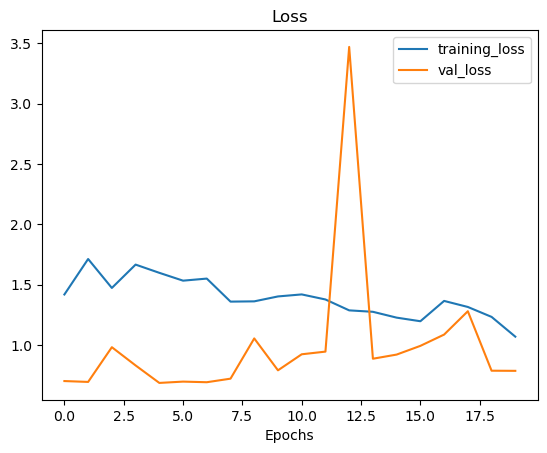

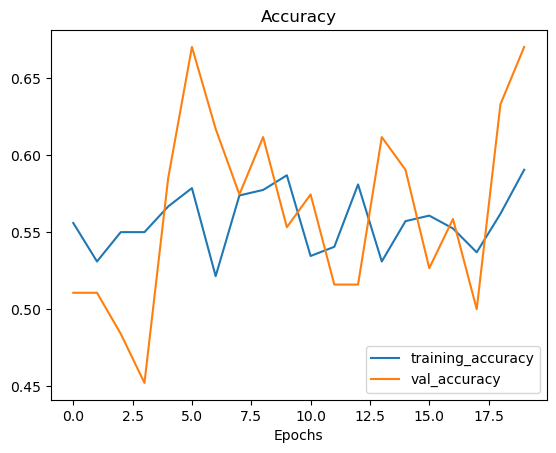

In [23]:
plot_loss_curves(history_two)

In [24]:
model_three = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(32,(3,3), activation='relu'), # first layer specifies input shape (height, width, colour channels)
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
], name="model_three")

In [25]:
model_three.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [26]:
checkpoint_path = "model_checkpoint_conv4"
mc = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
#                                                       save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=1) # don't print out whether or not model is being saved

In [27]:
history_three = model_three.fit(train_data,
                        epochs=20,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[mc])

Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 0.8861 - accuracy: 0.5369
Epoch 1: val_accuracy improved from -inf to 0.48404, saving model to model_checkpoint_conv4
INFO:tensorflow:Assets written to: model_checkpoint_conv4\assets


INFO:tensorflow:Assets written to: model_checkpoint_conv4\assets


27/27 [==============================] - 200s 7s/step - loss: 0.8861 - accuracy: 0.5369 - val_loss: 0.7328 - val_accuracy: 0.4840
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 0.7574 - accuracy: 0.6083 
Epoch 2: val_accuracy did not improve from 0.48404
27/27 [==============================] - 805s 31s/step - loss: 0.7574 - accuracy: 0.6083 - val_loss: 1.0159 - val_accuracy: 0.4840
Epoch 3/20
27/27 [==============================] - ETA: 0s - loss: 0.7458 - accuracy: 0.6143
Epoch 3: val_accuracy did not improve from 0.48404
27/27 [==============================] - 179s 7s/step - loss: 0.7458 - accuracy: 0.6143 - val_loss: 1.7851 - val_accuracy: 0.4840
Epoch 4/20
27/27 [==============================] - ETA: 0s - loss: 0.8099 - accuracy: 0.5929
Epoch 4: val_accuracy did not improve from 0.48404
27/27 [==============================] - 179s 7s/step - loss: 0.8099 - accuracy: 0.5929 - val_loss: 1.6990 - val_accuracy: 0.4840
Epoch 5/20
27/27 [=========================

INFO:tensorflow:Assets written to: model_checkpoint_conv4\assets


27/27 [==============================] - 198s 7s/step - loss: 0.5860 - accuracy: 0.7226 - val_loss: 0.7927 - val_accuracy: 0.5372
Epoch 7/20
27/27 [==============================] - ETA: 0s - loss: 0.5530 - accuracy: 0.7333
Epoch 7: val_accuracy did not improve from 0.53723
27/27 [==============================] - 180s 7s/step - loss: 0.5530 - accuracy: 0.7333 - val_loss: 0.7535 - val_accuracy: 0.4149
Epoch 8/20
27/27 [==============================] - ETA: 0s - loss: 0.5359 - accuracy: 0.7726
Epoch 8: val_accuracy did not improve from 0.53723
27/27 [==============================] - 177s 7s/step - loss: 0.5359 - accuracy: 0.7726 - val_loss: 0.9967 - val_accuracy: 0.5160
Epoch 9/20
27/27 [==============================] - ETA: 0s - loss: 0.4269 - accuracy: 0.8119
Epoch 9: val_accuracy did not improve from 0.53723
27/27 [==============================] - 179s 7s/step - loss: 0.4269 - accuracy: 0.8119 - val_loss: 1.0671 - val_accuracy: 0.5160
Epoch 10/20
27/27 [==========================

INFO:tensorflow:Assets written to: model_checkpoint_conv4\assets


27/27 [==============================] - 195s 7s/step - loss: 0.3871 - accuracy: 0.8429 - val_loss: 0.7763 - val_accuracy: 0.5798
Epoch 11/20
27/27 [==============================] - ETA: 0s - loss: 0.3568 - accuracy: 0.8560
Epoch 11: val_accuracy did not improve from 0.57979
27/27 [==============================] - 179s 7s/step - loss: 0.3568 - accuracy: 0.8560 - val_loss: 0.7872 - val_accuracy: 0.5106
Epoch 12/20
27/27 [==============================] - ETA: 0s - loss: 0.2592 - accuracy: 0.8917
Epoch 12: val_accuracy did not improve from 0.57979
27/27 [==============================] - 181s 7s/step - loss: 0.2592 - accuracy: 0.8917 - val_loss: 1.2753 - val_accuracy: 0.4734
Epoch 13/20
27/27 [==============================] - ETA: 0s - loss: 0.2883 - accuracy: 0.9000
Epoch 13: val_accuracy improved from 0.57979 to 0.60106, saving model to model_checkpoint_conv4
INFO:tensorflow:Assets written to: model_checkpoint_conv4\assets


INFO:tensorflow:Assets written to: model_checkpoint_conv4\assets


27/27 [==============================] - 199s 7s/step - loss: 0.2883 - accuracy: 0.9000 - val_loss: 0.7883 - val_accuracy: 0.6011
Epoch 14/20
27/27 [==============================] - ETA: 0s - loss: 0.3603 - accuracy: 0.8417
Epoch 14: val_accuracy improved from 0.60106 to 0.66489, saving model to model_checkpoint_conv4
INFO:tensorflow:Assets written to: model_checkpoint_conv4\assets


INFO:tensorflow:Assets written to: model_checkpoint_conv4\assets


27/27 [==============================] - 196s 7s/step - loss: 0.3603 - accuracy: 0.8417 - val_loss: 0.7231 - val_accuracy: 0.6649
Epoch 15/20
27/27 [==============================] - ETA: 0s - loss: 0.2871 - accuracy: 0.8714
Epoch 15: val_accuracy improved from 0.66489 to 0.67021, saving model to model_checkpoint_conv4
INFO:tensorflow:Assets written to: model_checkpoint_conv4\assets


INFO:tensorflow:Assets written to: model_checkpoint_conv4\assets


27/27 [==============================] - 197s 7s/step - loss: 0.2871 - accuracy: 0.8714 - val_loss: 0.7204 - val_accuracy: 0.6702
Epoch 16/20
27/27 [==============================] - ETA: 0s - loss: 0.2247 - accuracy: 0.9119
Epoch 16: val_accuracy did not improve from 0.67021
27/27 [==============================] - 182s 7s/step - loss: 0.2247 - accuracy: 0.9119 - val_loss: 0.7731 - val_accuracy: 0.6702
Epoch 17/20
27/27 [==============================] - ETA: 0s - loss: 0.1995 - accuracy: 0.9310
Epoch 17: val_accuracy did not improve from 0.67021
27/27 [==============================] - 179s 7s/step - loss: 0.1995 - accuracy: 0.9310 - val_loss: 0.9593 - val_accuracy: 0.6489
Epoch 18/20
27/27 [==============================] - ETA: 0s - loss: 0.1869 - accuracy: 0.9214
Epoch 18: val_accuracy improved from 0.67021 to 0.71277, saving model to model_checkpoint_conv4
INFO:tensorflow:Assets written to: model_checkpoint_conv4\assets


INFO:tensorflow:Assets written to: model_checkpoint_conv4\assets


27/27 [==============================] - 196s 7s/step - loss: 0.1869 - accuracy: 0.9214 - val_loss: 0.7057 - val_accuracy: 0.7128
Epoch 19/20
27/27 [==============================] - ETA: 0s - loss: 0.2691 - accuracy: 0.9000
Epoch 19: val_accuracy did not improve from 0.71277
27/27 [==============================] - 182s 7s/step - loss: 0.2691 - accuracy: 0.9000 - val_loss: 1.1180 - val_accuracy: 0.6330
Epoch 20/20
27/27 [==============================] - ETA: 0s - loss: 0.1872 - accuracy: 0.9274
Epoch 20: val_accuracy improved from 0.71277 to 0.77660, saving model to model_checkpoint_conv4
INFO:tensorflow:Assets written to: model_checkpoint_conv4\assets


INFO:tensorflow:Assets written to: model_checkpoint_conv4\assets


27/27 [==============================] - 198s 7s/step - loss: 0.1872 - accuracy: 0.9274 - val_loss: 0.6183 - val_accuracy: 0.7766


In [28]:
model_three_ev = model_three.evaluate(test_data)
model_three_ev

6/6 [==============================] - 9s 1s/step - loss: 0.6183 - accuracy: 0.7766


[0.6183466911315918, 0.7765957713127136]

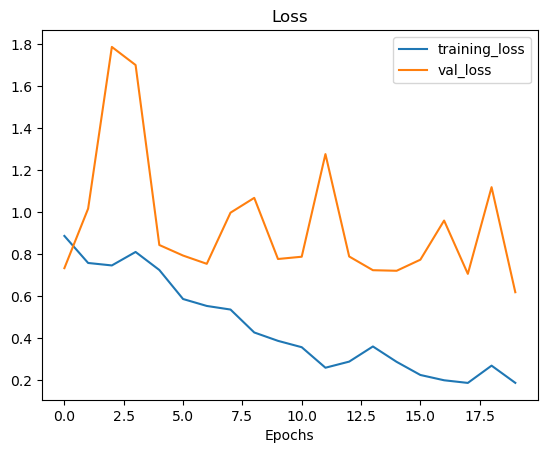

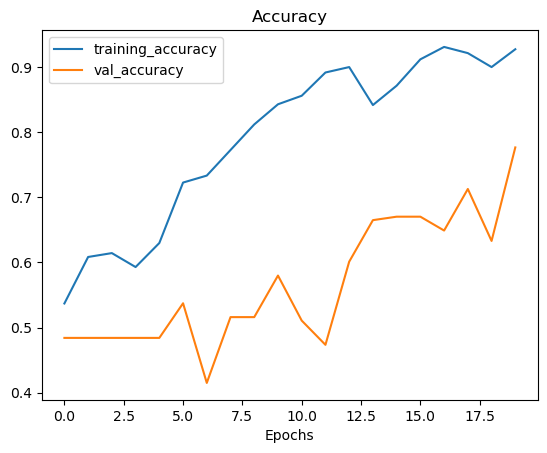

In [29]:
plot_loss_curves(history_three)

In [30]:
import pandas as pd

# Evaluate the models
eval_model_1 = model_one.evaluate(test_data, verbose=0)
eval_model_2 = model_two.evaluate(test_data, verbose=0)
eval_model_3 = model_three.evaluate(test_data, verbose=0)

# Create a dataframe to store the evaluation results
df_model = pd.DataFrame({
    'Model': ['Model 1', 'Model 2', 'Model 3'],
    'Loss': [eval_model_1[0], eval_model_2[0], eval_model_3[0]],
    'Accuracy': [eval_model_1[1], eval_model_2[1], eval_model_3[1]],
})

# Sort by accuracy
df_model = df_model.sort_values('Accuracy', ascending=False)

df_model

,Model,Loss,Accuracy
2,Model 3,0.618347,0.776596
0,Model 1,0.657494,0.739362
1,Model 2,0.786661,0.670213
